## Sentiment Classification: classifying IMDB reviews

The following notebook represents a class project focusing on neural networks with limited input text data, done using pre-trained embeddings by glove for sentiment classification (classifying a review document as "positive" or "negative" based solely on the text content of the review).

This is done via the 'Embedding' layer in keras to represent text input

#### a) IMBD Data

First off, the IMDB movie dataset is far too huge to upload online, so this link `http://ai.stanford.edu/~amaas/data/sentiment/` was used, into a directory called 'data' if you wish to replicate it yourself. The review labels will the be list of `labels` to the reviews, compressed into a string.

This section searches through both the positive and negative folders, reading exclusively text files (_just in case_) into a list, with the labels depending on whether the folder when reading is 'pos' or 'neg'. <br> An initial approach was to determine if the rating post underscore (f.e: '129_4.txt') was above/beneath a threshold (5-6), as positive results all had ratings more than 6, and negative had ratings less than 5. This proved to be too extreme/redundant compared to this approach.

In [1]:
import os
data_dir = './data/aclImdb/'
train_dir = data_dir + 'train'
test_dir = data_dir + 'test'

labels = []
texts = []
sentiments = ['neg', 'pos']

for label_type in sentiments:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
print(len(labels),len(texts))

texts1 = []
labels1 = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts1.append(f.read())
            f.close()
            if label_type == 'neg':
                labels1.append(0)
            else:
                labels1.append(1)
print(len(labels1),len(texts1))

25000 25000


#### b) Pre-process the review documents 
Rather than using NLTK and Regex, Keras had the Tokenizer, which performs most of the actions required. The tokenizer pre-processing parameters are such that it considers only up to 10,000 words (_instead of 5000, which is because of the model later_), lowercases all words, and removes all non-alphanumeric characters. <br>
The tokenizer transforms the training data into an integer sequence for the sake of vectorizing, which will be used with the embedding matrix later. As a precaution, the dataset was shuffled again, and split such that the first 1000 is the training set, and the next 10000 is the validation set (11000/25000 used).

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import numpy as np
# print(len(data),len(label))

maxlen = 100  #Cut reviews after 100 words
training_samples = 1000  # First 1000 reviews
validation_samples = 10000 # Validation samples are 10000 after train
max_words = 10000  # Top 10,000 words in the dataset instead of 5000

token = Tokenizer(num_words=max_words, lower=True, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
token.fit_on_texts(texts)
sequences = token.texts_to_sequences(texts)
word_index = token.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=100)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]
print(len(x_train), len(x_val))

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)
1000 10000


The test data was also pre-processed in the same manner, but was not split.

In [6]:
sequences1 = token.texts_to_sequences(texts1)
data1 = pad_sequences(sequences1, maxlen=maxlen)
labels1 = np.asarray(labels1)

indices = np.arange(data1.shape[0])
np.random.shuffle(indices)
x_test = data1[indices]
y_test = labels[indices]

#### c) GloVe Embedding
Glove is an even bigger repository containing the word embeddings needed for this Natural Language Processing project. Since upload is impossible, steps to acquire it will be hosted here instead. 

--------------------
Link: `https://nlp.stanford.edu/projects/glove/` 
Filename:  `glove.6B.zip`
Details: Contains 100-dimensional embedding vectors for 400,000 words (or non-word tokens), all as a `.txt` file

The following section parses said file to index map the words to their vector representation (numbers), known as an embedding matrix. Note that to handle this with the `Embedding` layer from Keras later, the input shape needs to be `(max_words, embedding_dim)`, where entry `i` contains `embedding-dim`, the vector

Here the 100 dimension textfile is loaded into a 100x100 matrix, where each entry is the word vector. Note that the print statement indicates the amount of word vectors inside that file, but far less are being used inside this matrix. Each word vector will be weighted accordingly, both from occurrence/frequency and weight coefficients from GloVe. If there isn't a word found in the embedding, that matrix entry will be empty (_all zeros_).

In [7]:
file_dir = './glove.6B/glove.6B.100d.txt'
# write your code here
embeddings_index = {}
with open(file_dir,'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
print('Found %s word vectors.' % len(embeddings_index))

#Populate all entries with zeros. Only fill entries with matching word vectors
embedding_matrix = np.zeros((max_words, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


#### Sequential Model
A basic sequential model, consisting of the embedding layer (_which asks to be 10,000 tokens max, contradicting the initial statement of 5,000. So the previous was upped to 10k._), the flattening layer, and dense layers. Sigmoid was used to perform binary classification (positive/negative). <br>
The trainable attribute was also frozen to prevent updating, as these weights by glove are already pre-trained, and will be skewed/messed if updated per epoch. The standard/safe number of epochs (20-30) and batch amount (32) were used. <br> The training accuracy whilst training was suspiciously around 0.99~1.00, with the validation accuracy barely improving.

In [8]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, Conv1D, MaxPooling1D


# write your code here
model = Sequential()
model.add(Embedding(10000, 100, input_length=100))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=32,validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 1000 samples, validate on 10000 samples
Epoch 1/20
1000/1000 [==============================] - 1s 702us/step - loss: 0.9702 - acc: 0.5220 - val_loss: 0.7353 - val_acc: 0.5103
Epoch 2/20
1000/1000 [=========

#### Results obvservation
The results show that the data is obviously overfitted, with the validation data experiencing no improvement in accuracy, yet the training data having a near 1.0 accuracy. This is also apparent in the training loss nearing 0, validation loss going above 1, and the accuracy score of being around 0.5 post evaluation (_Equivalent to random guessing, or guessing entirely on a single class_) This could be due to the small dataset size, or the lack of LSTM/Convolutional Layer to effectively differentiate/learn.

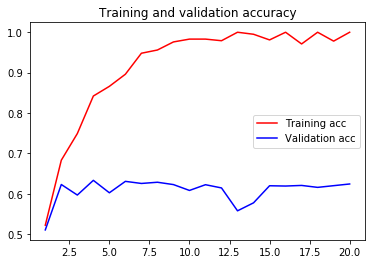

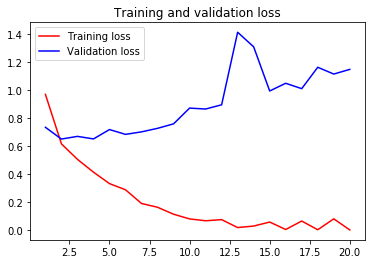

25000/25000 [==============================] - 1s 39us/step
Accuracy: 50%


In [31]:
import matplotlib.pyplot as plt

# write your code here
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
loss,acc = model.evaluate(x_test,y_test)
print('Accuracy: {:.0%}'.format(acc))

#### Hyperparameter Exploration
Several other experimentations were done to determine what improves the model performance.
* Adding additional LSTM Layers appeared to worsen the validation accuracy as the training goes
* Adding Dropout was necessary to prevent the overfitting from happening too soon (_It still does, but slower_), which had to be around 50%
* Altering the LSTM filter amount to a smaller amount (32 rather than 100) appeared to solve the overfitting best, making the validation accuracy almost identical to the training data
* Altering the Dense layer filter amount to a smaller value also improved the model's performance

In [55]:
from keras.layers import LSTM

# write your code here
model1 = Sequential()
model1.add(Embedding(10000, 100, input_length=100))
model1.add(LSTM(32))
model1.add(Dropout(0.5))
# model1.add(Flatten())
# model1.add(LSTM(100))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()

model1.layers[0].set_weights([embedding_matrix])
model1.layers[0].trainable = False

model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history1 = model1.fit(x_train, y_train, epochs=20, batch_size=32,validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
lstm_23 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 33        
Total params: 1,018,113
Trainable params: 1,018,113
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 10000 samples
Epoch 1/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.7034 

Whilst the accuracy appears to be the same, score-wise the LSTM model has an improvement of around ~0.02 higher scoring, with less overfitting occuring on the datasets. The accuracy can be attributed to the lack of available data to train (_1000 entries is too small_)

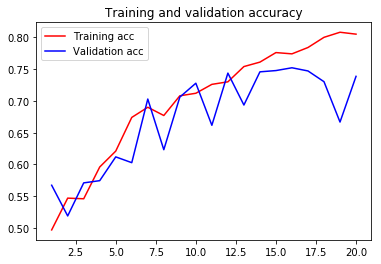

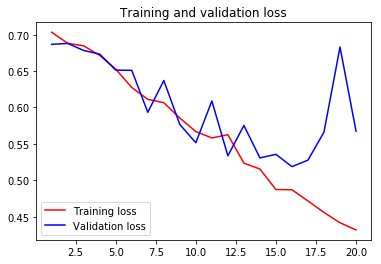

25000/25000 [==============================] - 6s 242us/step
Accuracy: 50%


In [59]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
loss, acc = model1.evaluate(x_test, y_test)
print('Accuracy: {:.0%}'.format(acc))

#### Closing thoughts
From here, the idea was to repeatedly fine-tune the model hyperparameters until the accuracy hits a decent score of >70%. However, given how small the data size is, there is a chance that bias may have occured with the given selection, and that finding more was too much of a hassle at this given time. Therefore, it will be left as is with the assumption that tweaking is simply done from here on out, but otherwise:

A model that predicts positive/negative from tweets is made